<a href="https://colab.research.google.com/github/SvZol/IntroductionToAI/blob/main/Part_II_Classification_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part II: Classical Classification on CIFAR-10
**Introduction to Artificial Intelligence — Final Project**

This notebook covers **Part II** of the project:
- Data loading and preprocessing (full dataset — 50,000 training examples)
- Logistic Regression (Softmax), Linear SVM, KNN
- Hyperparameter selection via validation accuracy
- Confusion matrices and model comparison
- Final evaluation on the test set


## 2.1 Load CIFAR-10

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle, os
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Download CIFAR-10 if needed
import os
if not os.path.exists('cifar-10-batches-py'):
    os.system('wget -q https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz')
    os.system('tar -xzf cifar-10-python.tar.gz')

def load_cifar10_batch(filepath):
    with open(filepath, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    return batch[b'data'], np.array(batch[b'labels'])

def load_cifar10(data_dir):
    Xs, ys = [], []
    for i in range(1, 6):
        X, y = load_cifar10_batch(os.path.join(data_dir, f'data_batch_{i}'))
        Xs.append(X); ys.append(y)
    X_train = np.concatenate(Xs); y_train = np.concatenate(ys)
    X_test, y_test = load_cifar10_batch(os.path.join(data_dir, 'test_batch'))
    return X_train, y_train, X_test, y_test

X_train_full, y_train_full, X_test_full, y_test_full = load_cifar10('cifar-10-batches-py')

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"CIFAR-10 loaded:")
print(f"  Training set: {X_train_full.shape}  ({X_train_full.shape[0]} examples)")
print(f"  Test set:     {X_test_full.shape}")
print(f"  Classes:      {class_names}")

CIFAR-10 loaded:
  Training set: (50000, 3072)  (50000 examples)
  Test set:     (10000, 3072)
  Classes:      ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


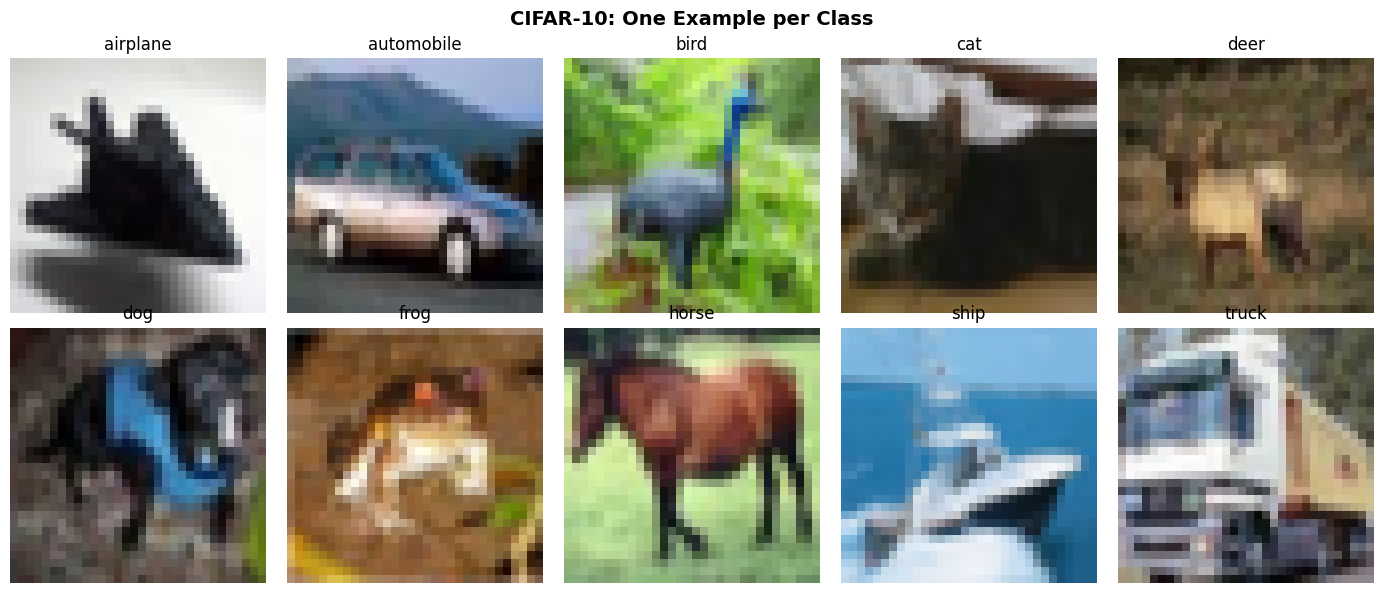

In [ ]:
# Visualize examples
fig, axes = plt.subplots(2, 5, figsize=(14, 6))
for class_idx, ax in enumerate(axes.ravel()):
    img_idx = np.where(y_train_full == class_idx)[0][0]
    img = X_train_full[img_idx].reshape(3, 32, 32).transpose(1, 2, 0)
    ax.imshow(img); ax.set_title(class_names[class_idx], fontsize=12); ax.axis('off')
plt.suptitle('CIFAR-10: One Example per Class', fontsize=14, fontweight='bold')
plt.tight_layout(); plt.show()

## 2.2 Preprocessing — Full Training Set

In [ ]:
# ─── FULL dataset ───────────────────────────────────────────────────────────
# Normalize pixel values to [0, 1]
X_all   = X_train_full.astype(np.float32) / 255.0   # (50000, 3072)
y_all   = y_train_full
X_test_raw = X_test_full.astype(np.float32) / 255.0  # (10000, 3072)
y_test_clf = y_test_full

# Train / Validation split: 80% / 20% from the 50,000 training examples
X_train_clf, X_val_clf, y_train_clf, y_val_clf = train_test_split(
    X_all, y_all, test_size=0.20, random_state=42, stratify=y_all
)

# Standardize
scaler_clf = StandardScaler()
X_train_scaled = scaler_clf.fit_transform(X_train_clf)
X_val_scaled   = scaler_clf.transform(X_val_clf)
X_test_scaled  = scaler_clf.transform(X_test_raw)

print(f"Preprocessing complete:")
print(f"  Train:      {X_train_scaled.shape}  →  {y_train_clf.shape[0]} examples")
print(f"  Validation: {X_val_scaled.shape}  →  {y_val_clf.shape[0]} examples")
print(f"  Test:       {X_test_scaled.shape}  →  {y_test_clf.shape[0]} examples (LOCKED)")
print(f"\nNote: using all 40,000 training examples for LR and SVM.")
print(f"KNN will use PCA-reduced features (see Section 2.4).")

Preprocessing complete:
  Train:      (40000, 3072)  →  40000 examples
  Validation: (10000, 3072)  →  10000 examples
  Test:       (10000, 3072)  →  10000 examples (LOCKED)

Note: using all 40,000 training examples for LR and SVM.
KNN will use PCA-reduced features (see Section 2.4).


## 2.3 Model 1 — Logistic Regression (Softmax)

MODEL 1: LOGISTIC REGRESSION (SOFTMAX)

Hyperparameter search — regularization strength C:
  C=1e-05   : Val Accuracy = 0.3465
  C=0.0001  : Val Accuracy = 0.3871
  C=0.001   : Val Accuracy = 0.3944
  C=0.01    : Val Accuracy = 0.3685
  C=0.1     : Val Accuracy = 0.3269
  C=1.0     : Val Accuracy = 0.2877

Best C = 0.001

Logistic Regression (C=0.001):
  Train Accuracy: 0.4565
  Val Accuracy:   0.4158
  Gap (overfit?): 0.0407


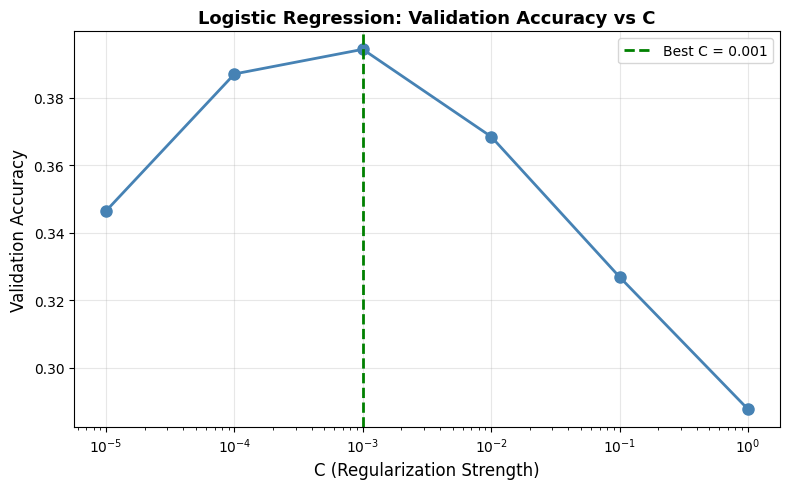

In [ ]:
from sklearn.linear_model import LogisticRegression

print("="*70)
print("MODEL 1: LOGISTIC REGRESSION (SOFTMAX)")
print("="*70)

np.random.seed(42)
search_idx = np.random.choice(len(X_train_scaled), size=10000, replace=False)
X_search = X_train_scaled[search_idx]
y_search = y_train_clf[search_idx]

C_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
lr_val_accs = []

print("\nHyperparameter search — regularization strength C:")
for C in C_values:
    lr = LogisticRegression(
        C=C,
        max_iter=500,
        solver='lbfgs',
        multi_class='multinomial',
        random_state=42,
        n_jobs=-1,
        tol=1e-3
    )
    lr.fit(X_search, y_search)
    val_acc = accuracy_score(y_val_clf, lr.predict(X_val_scaled))
    lr_val_accs.append(val_acc)
    print(f"  C={C:<8}: Val Accuracy = {val_acc:.4f}")

best_C_lr = C_values[np.argmax(lr_val_accs)]
print(f"\nBest C = {best_C_lr}")

lr_final = LogisticRegression(
    C=best_C_lr,
    max_iter=1000,
    solver='lbfgs',
    multi_class='multinomial',
    random_state=42,
    n_jobs=-1,
    tol=1e-3
)
lr_final.fit(X_train_scaled, y_train_clf)
print(f"\nLogistic Regression (C={best_C_lr}):")

lr_train_acc = accuracy_score(y_train_clf, lr_final.predict(X_train_scaled))
lr_val_acc   = accuracy_score(y_val_clf,   lr_final.predict(X_val_scaled))

print(f"  Train Accuracy: {lr_train_acc:.4f}")
print(f"  Val Accuracy:   {lr_val_acc:.4f}")
print(f"  Gap (overfit?): {lr_train_acc - lr_val_acc:.4f}")

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(C_values, lr_val_accs, 'o-', linewidth=2, markersize=8, color='steelblue')
ax.axvline(x=best_C_lr, color='green', linestyle='--', linewidth=2, label=f'Best C = {best_C_lr}')
ax.set_xscale('log')
ax.set_xlabel('C (Regularization Strength)', fontsize=12)
ax.set_ylabel('Validation Accuracy', fontsize=12)
ax.set_title('Logistic Regression: Validation Accuracy vs C', fontsize=13, fontweight='bold')
ax.legend(); ax.grid(alpha=0.3); plt.tight_layout(); plt.show()

## 2.4 Model 2 — Linear SVM

MODEL 2: LINEAR SVM

Hyperparameter search — regularization strength C:
  C=1e-06   : Val Accuracy = 0.3550
  C=1e-05   : Val Accuracy = 0.3897
  C=0.0001  : Val Accuracy = 0.3877
  C=0.001   : Val Accuracy = 0.3622
  C=0.01    : Val Accuracy = 0.3285

Best C = 1e-05


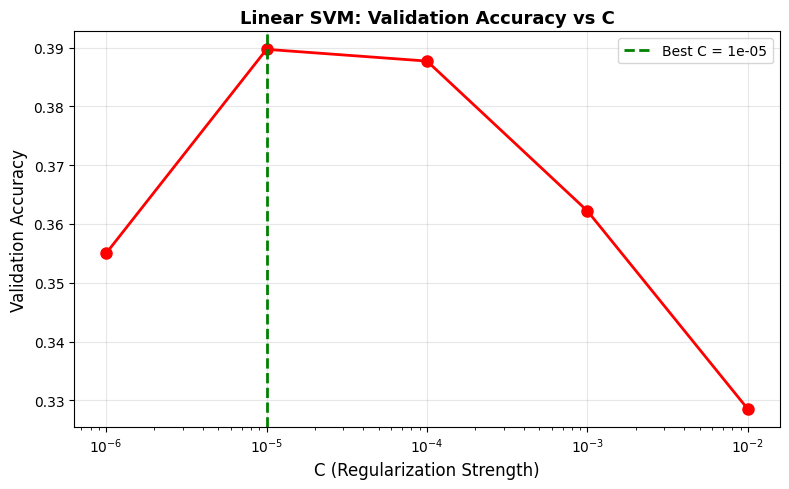


Linear SVM (C=1e-05):
  Train Accuracy: 0.4273
  Val Accuracy:   0.4108
  Gap (overfit?): 0.0165


In [ ]:
from sklearn.svm import LinearSVC

print("="*70)
print("MODEL 2: LINEAR SVM")
print("="*70)

np.random.seed(42)
search_idx = np.random.choice(len(X_train_scaled), size=10000, replace=False)
X_search = X_train_scaled[search_idx]
y_search = y_train_clf[search_idx]

C_values_svm = [0.000001, 0.00001, 0.0001, 0.001, 0.01]
svm_val_accs = []

print("\nHyperparameter search — regularization strength C:")
for C in C_values_svm:
    svm = LinearSVC(C=C, max_iter=1000, random_state=42, tol=1e-3)
    svm.fit(X_search, y_search)
    val_acc = accuracy_score(y_val_clf, svm.predict(X_val_scaled))
    svm_val_accs.append(val_acc)
    print(f"  C={C:<8}: Val Accuracy = {val_acc:.4f}")

best_C_svm = C_values_svm[np.argmax(svm_val_accs)]
print(f"\nBest C = {best_C_svm}")

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(C_values_svm, svm_val_accs, 'o-', linewidth=2, markersize=8, color='red')
ax.axvline(x=best_C_svm, color='green', linestyle='--', linewidth=2, label=f'Best C = {best_C_svm}')
ax.set_xscale('log'); ax.set_xlabel('C (Regularization Strength)', fontsize=12)
ax.set_ylabel('Validation Accuracy', fontsize=12)
ax.set_title('Linear SVM: Validation Accuracy vs C', fontsize=13, fontweight='bold')
ax.legend(); ax.grid(alpha=0.3); plt.tight_layout(); plt.show()

svm_final = LinearSVC(C=best_C_svm, max_iter=1000, random_state=42, tol=1e-3)
svm_final.fit(X_train_scaled, y_train_clf)
print(f"\nLinear SVM (C={best_C_svm}):")

svm_train_acc = accuracy_score(y_train_clf, svm_final.predict(X_train_scaled))
svm_val_acc   = accuracy_score(y_val_clf,   svm_final.predict(X_val_scaled))

print(f"  Train Accuracy: {svm_train_acc:.4f}")
print(f"  Val Accuracy:   {svm_val_acc:.4f}")
print(f"  Gap (overfit?): {svm_train_acc - svm_val_acc:.4f}")

## 2.5 Model 3 — KNN (with PCA)

MODEL 3: KNN CLASSIFICATION (with PCA dimensionality reduction)

--- Step 1: PCA component search (subsample n=5 000) ---
  (fixed k=10 during PCA search)
  n_components=20  : Val Accuracy = 0.3385
  n_components=50  : Val Accuracy = 0.3272
  n_components=100 : Val Accuracy = 0.3107
  n_components=150 : Val Accuracy = 0.2995
  n_components=200 : Val Accuracy = 0.2958

  Best n_components = 20


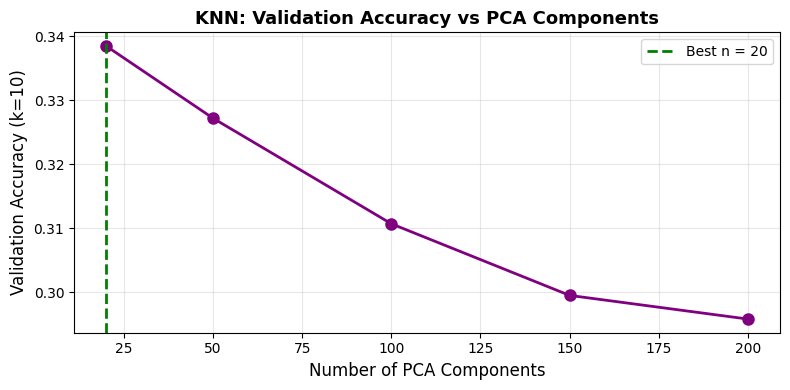

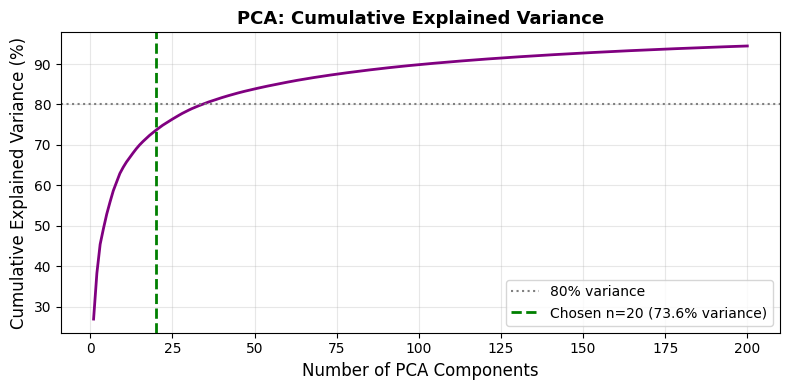

  Chosen: 20 components → 73.6% variance retained
  Explained variance retained: 73.6%

--- Step 2: k search on full training set (PCA-20) ---
  k=1   : Train=1.0000  Val=0.3705
  k=3   : Train=0.6279  Val=0.3670
  k=5   : Train=0.5764  Val=0.3894
  k=7   : Train=0.5417  Val=0.3995
  k=10  : Train=0.5145  Val=0.3996
  k=15  : Train=0.4867  Val=0.4047
  k=20  : Train=0.4726  Val=0.3970
  k=30  : Train=0.4513  Val=0.3988
  k=50  : Train=0.4284  Val=0.3945

  Best k = 15  (Val Accuracy = 0.4047)


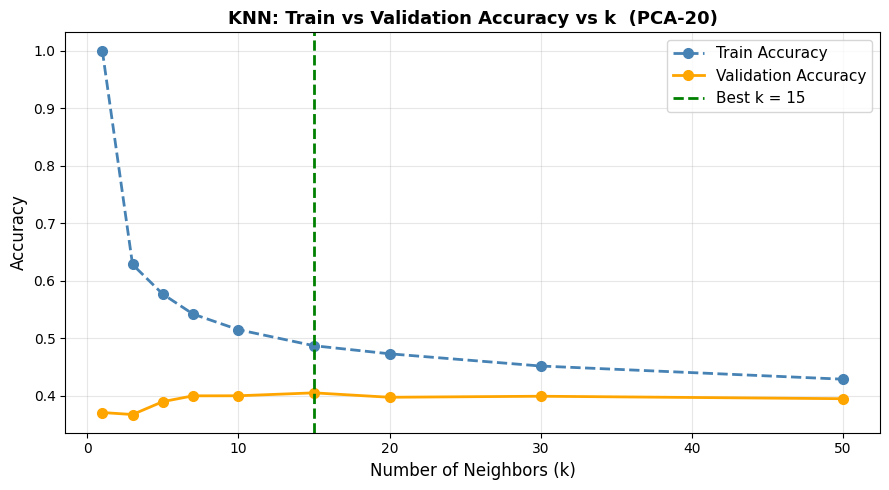


KNN (k=15, PCA-20):
  Train Accuracy: 0.4867
  Val Accuracy:   0.4047
  Gap (overfit?): 0.0820


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

print("=" * 70)
print("MODEL 3: KNN CLASSIFICATION (with PCA dimensionality reduction)")
print("=" * 70)

# Step 1: Choose optimal number of PCA components
# PCA dimensionality is itself a hyperparameter — we search over candidate
# values using a subsample (5 000 examples) to keep runtime manageable.
# KNN is a lazy learner (fit = O(1)), so the bottleneck is prediction time.

print("\n--- Step 1: PCA component search (subsample n=5 000) ---")

np.random.seed(42)
sub_idx = np.random.choice(len(X_train_scaled), size=5_000, replace=False)
X_sub = X_train_scaled[sub_idx]
y_sub = y_train_clf[sub_idx]

n_components_list = [20, 50, 100, 150, 200]
pca_search_accs = []

# Use a fixed k=10 during PCA search (reasonable mid-range value)
K_FIXED = 10
print(f"  (fixed k={K_FIXED} during PCA search)")
for n in n_components_list:
    pca_tmp = PCA(n_components=n, random_state=42)
    X_sub_pca  = pca_tmp.fit_transform(X_sub)
    X_val_tmp  = pca_tmp.transform(X_val_scaled)
    knn_tmp = KNeighborsClassifier(n_neighbors=K_FIXED, n_jobs=-1)
    knn_tmp.fit(X_sub_pca, y_sub)
    acc = accuracy_score(y_val_clf, knn_tmp.predict(X_val_tmp))
    pca_search_accs.append(acc)
    print(f"  n_components={n:<4}: Val Accuracy = {acc:.4f}")

best_n = n_components_list[np.argmax(pca_search_accs)]
print(f"\n  Best n_components = {best_n}")

# Plot: Val accuracy vs PCA components
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(n_components_list, pca_search_accs, 'o-', linewidth=2,
        markersize=8, color='purple')
ax.axvline(x=best_n, color='green', linestyle='--', linewidth=2,
           label=f'Best n = {best_n}')
ax.set_xlabel('Number of PCA Components', fontsize=12)
ax.set_ylabel('Validation Accuracy (k=10)', fontsize=12)
ax.set_title('KNN: Validation Accuracy vs PCA Components', fontsize=13,
             fontweight='bold')
ax.legend(); ax.grid(alpha=0.3); plt.tight_layout(); plt.show()

#Plot explained variance for the chosen n
pca_full = PCA(n_components=max(n_components_list), random_state=42)
pca_full.fit(X_train_scaled)
cumvar = np.cumsum(pca_full.explained_variance_ratio_) * 100

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(1, max(n_components_list) + 1), cumvar, linewidth=2, color='purple')
ax.axhline(y=80, color='gray', linestyle=':', label='80% variance')
ax.axvline(x=best_n, color='green', linestyle='--', linewidth=2,
           label=f'Chosen n={best_n} ({cumvar[best_n-1]:.1f}% variance)')
ax.set_xlabel('Number of PCA Components', fontsize=12)
ax.set_ylabel('Cumulative Explained Variance (%)', fontsize=12)
ax.set_title('PCA: Cumulative Explained Variance', fontsize=13, fontweight='bold')
ax.legend(); ax.grid(alpha=0.3); plt.tight_layout(); plt.show()
print(f"  Chosen: {best_n} components → {cumvar[best_n-1]:.1f}% variance retained")

# Apply PCA with the chosen n_components to the FULL training set
pca = PCA(n_components=best_n, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca   = pca.transform(X_val_scaled)
X_test_pca  = pca.transform(X_test_scaled)
explained_var = np.sum(pca.explained_variance_ratio_) * 100
print(f"  Explained variance retained: {explained_var:.1f}%")

# Step 2: Search over k
# Now we search over k using the full training set and the chosen PCA space.
# We also track train accuracy to visualise the bias–variance tradeoff:
#   small k → low bias, high variance (overfits)
#   large k → high bias, low variance (underfits)

print(f"\n--- Step 2: k search on full training set (PCA-{best_n}) ---")

k_values_clf = [1, 3, 5, 7, 10, 15, 20, 30, 50]
knn_train_accs_search = []
knn_val_accs = []

for k in k_values_clf:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train_pca, y_train_clf)
    train_acc = accuracy_score(y_train_clf, knn.predict(X_train_pca))
    val_acc   = accuracy_score(y_val_clf,   knn.predict(X_val_pca))
    knn_train_accs_search.append(train_acc)
    knn_val_accs.append(val_acc)
    print(f"  k={k:<4}: Train={train_acc:.4f}  Val={val_acc:.4f}")

best_k_clf = k_values_clf[np.argmax(knn_val_accs)]
print(f"\n  Best k = {best_k_clf}  (Val Accuracy = {max(knn_val_accs):.4f})")

#Plot: Train vs Val accuracy as a function of k
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(k_values_clf, knn_train_accs_search, 'o--', linewidth=2, markersize=7,
        color='steelblue', label='Train Accuracy')
ax.plot(k_values_clf, knn_val_accs, 'o-', linewidth=2, markersize=7,
        color='orange', label='Validation Accuracy')
ax.axvline(x=best_k_clf, color='green', linestyle='--', linewidth=2,
           label=f'Best k = {best_k_clf}')
ax.set_xlabel('Number of Neighbors (k)', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title(f'KNN: Train vs Validation Accuracy vs k  (PCA-{best_n})',
             fontsize=13, fontweight='bold')
ax.legend(fontsize=11); ax.grid(alpha=0.3); plt.tight_layout(); plt.show()

#Final model
knn_final_clf = KNeighborsClassifier(n_neighbors=best_k_clf, n_jobs=-1)
knn_final_clf.fit(X_train_pca, y_train_clf)
print(f"\nKNN (k={best_k_clf}, PCA-{best_n}):")

knn_train_acc = accuracy_score(y_train_clf, knn_final_clf.predict(X_train_pca))
knn_val_acc   = accuracy_score(y_val_clf,   knn_final_clf.predict(X_val_pca))
print(f"  Train Accuracy: {knn_train_acc:.4f}")
print(f"  Val Accuracy:   {knn_val_acc:.4f}")
print(f"  Gap (overfit?): {knn_train_acc - knn_val_acc:.4f}")


## 2.6 Confusion Matrices

CONFUSION MATRICES (Validation Set)


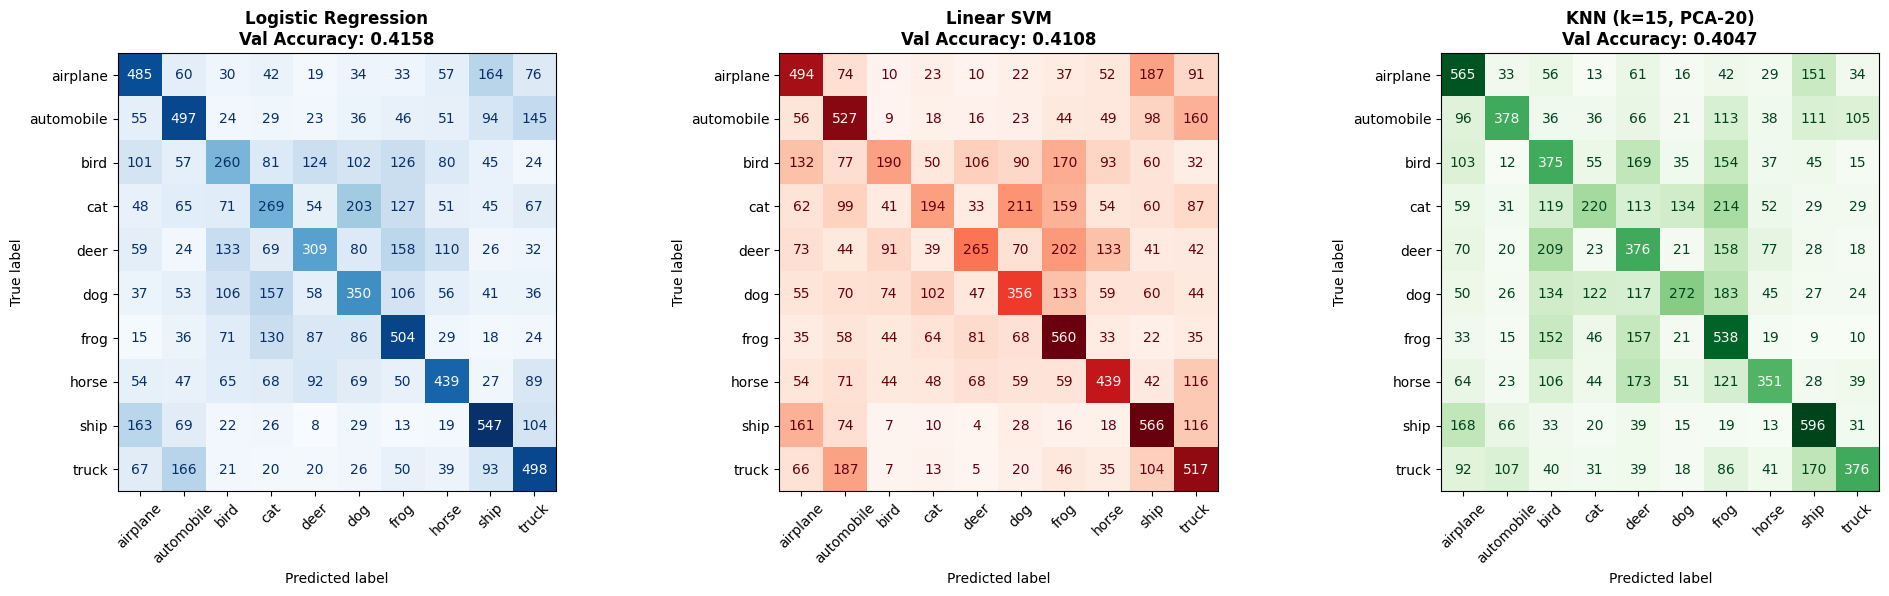

In [ ]:
print("="*70)
print("CONFUSION MATRICES (Validation Set)")
print("="*70)

models_clf = [
    ('Logistic Regression',          lr_final,      X_val_scaled, 'Blues'),
    ('Linear SVM',                   svm_final,     X_val_scaled, 'Reds'),
    (f'KNN (k={best_k_clf}, PCA-{best_n})', knn_final_clf, X_val_pca, 'Greens'),
]

results_clf = pd.DataFrame({
    'Model':           ['Logistic Regression', 'Linear SVM', f'KNN (k={best_k_clf}, PCA-50)'],
    'Best Hyperparam': [f'C={best_C_lr}', f'C={best_C_svm}', f'k={best_k_clf}'],
    'Train Accuracy':  [lr_train_acc, svm_train_acc, knn_train_acc],
    'Val Accuracy':    [lr_val_acc,   svm_val_acc,   knn_val_acc],
    'Train-Val Gap':   [lr_train_acc - lr_val_acc,
                        svm_train_acc - svm_val_acc,
                        knn_train_acc - knn_val_acc],
})

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, (name, model, X_val_m, cmap) in zip(axes, models_clf):
    y_pred = model.predict(X_val_m)
    cm = confusion_matrix(y_val_clf, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(ax=ax, cmap=cmap, colorbar=False, xticks_rotation=45)
    acc = accuracy_score(y_val_clf, y_pred)
    ax.set_title(f'{name}\nVal Accuracy: {acc:.4f}', fontsize=12, fontweight='bold')

plt.tight_layout(); plt.show()

In [ ]:
from sklearn.metrics import classification_report
print("\n--- Classification Report: Best Model (Logistic Regression) ---")
print(classification_report(y_val_clf, lr_final.predict(X_val_scaled),
                             target_names=class_names))


--- Classification Report: Best Model (Logistic Regression) ---
              precision    recall  f1-score   support

    airplane       0.45      0.48      0.47      1000
  automobile       0.46      0.50      0.48      1000
        bird       0.32      0.26      0.29      1000
         cat       0.30      0.27      0.28      1000
        deer       0.39      0.31      0.34      1000
         dog       0.34      0.35      0.35      1000
        frog       0.42      0.50      0.46      1000
       horse       0.47      0.44      0.45      1000
        ship       0.50      0.55      0.52      1000
       truck       0.45      0.50      0.48      1000

    accuracy                           0.42     10000
   macro avg       0.41      0.42      0.41     10000
weighted avg       0.41      0.42      0.41     10000



## 2.7 Model Comparison and Discussion

MODEL COMPARISON AND DISCUSSION


,Model,Best Hyperparam,Val Accuracy
0,Logistic Regression,C=0.001,0.4158
1,Linear SVM,C=1e-05,0.4108
2,"KNN (k=15, PCA-20)",k=15,0.4047


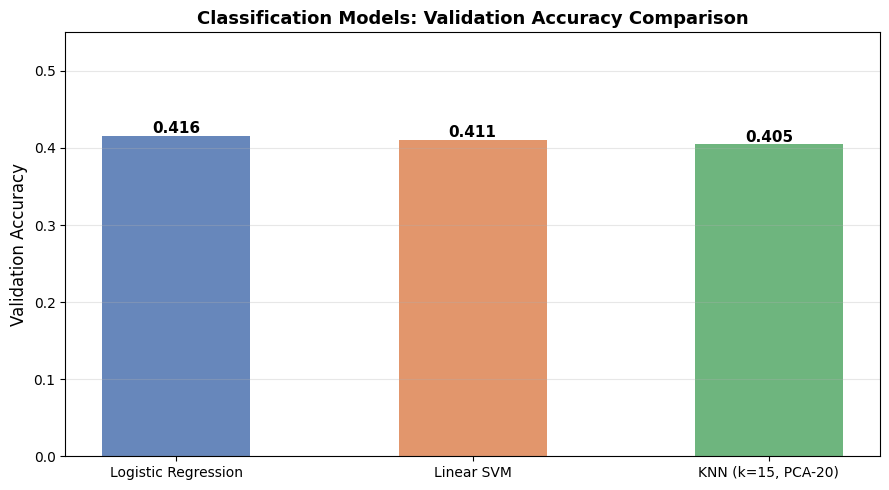


--- Per-Class Analysis (from Confusion Matrices) ---

  Logistic Regression:
    Best  recognized class: ship         (54.70%)
    Worst recognized class: bird         (26.00%)
    Most common confusion:  'cat' predicted as 'dog'

  Linear SVM:
    Best  recognized class: ship         (56.60%)
    Worst recognized class: bird         (19.00%)
    Most common confusion:  'cat' predicted as 'dog'

  KNN (PCA-50):
    Best  recognized class: ship         (59.60%)
    Worst recognized class: cat          (22.00%)
    Most common confusion:  'cat' predicted as 'frog'


In [ ]:
print("="*70)
print("MODEL COMPARISON AND DISCUSSION")
print("="*70)

results_clf = pd.DataFrame({
    'Model':           ['Logistic Regression', 'Linear SVM', f'KNN (k={best_k_clf}, PCA-{best_n})'],
    'Best Hyperparam': [f'C={best_C_lr}', f'C={best_C_svm}', f'k={best_k_clf}'],
    'Val Accuracy':    [lr_val_acc, svm_val_acc, knn_val_acc],
})
display(results_clf.round(4))

fig, ax = plt.subplots(figsize=(9, 5))
colors = ['#4C72B0', '#DD8452', '#55A868']
bars = ax.bar(results_clf['Model'], results_clf['Val Accuracy'],
              color=colors, alpha=0.85, width=0.5)
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.003,
            f'{bar.get_height():.3f}', ha='center', fontsize=11, fontweight='bold')
ax.set_ylabel('Validation Accuracy', fontsize=12)
ax.set_title('Classification Models: Validation Accuracy Comparison', fontsize=13, fontweight='bold')
ax.set_ylim(0, 0.55); ax.grid(axis='y', alpha=0.3)
plt.tight_layout(); plt.show()

# ── Per-class analysis from confusion matrices ──
print("\n--- Per-Class Analysis (from Confusion Matrices) ---")
for name, model, X_val_m in [
    ('Logistic Regression', lr_final,      X_val_scaled),
    ('Linear SVM',          svm_final,     X_val_scaled),
    ('KNN (PCA-50)',        knn_final_clf, X_val_pca),
]:
    y_pred = model.predict(X_val_m)
    cm = confusion_matrix(y_val_clf, y_pred)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    best_cls  = class_names[np.argmax(per_class_acc)]
    worst_cls = class_names[np.argmin(per_class_acc)]
    print(f"\n  {name}:")
    print(f"    Best  recognized class: {best_cls:<12} ({per_class_acc.max():.2%})")
    print(f"    Worst recognized class: {worst_cls:<12} ({per_class_acc.min():.2%})")
    np.fill_diagonal(cm, 0)
    err_true, err_pred = np.unravel_index(cm.argmax(), cm.shape)
    print(f"    Most common confusion:  '{class_names[err_true]}' predicted as '{class_names[err_pred]}'")

**1. Overall Performance**

All three models achieve validation accuracy in the range of 40–42% on CIFAR-10,
substantially above the random baseline of 10% (uniform over 10 classes), yet far
below human-level performance (~94%).  The final ranking by validation accuracy is:

| Model | Train Acc | Val Acc | Train−Val Gap |
|---|---|---|---|
| Logistic Regression (C=0.001) | 45.65% | **41.58%** | 4.07% |
| Linear SVM (C=1e-05) | 42.73% | 41.08% | 1.65% |
| KNN (k=15, PCA-20) | 48.67% | 40.47% | 8.20% |

Logistic Regression was selected as the final model based on validation accuracy
and evaluated on the test set **once**, yielding **41.57%** — almost identical to
its validation score (41.58%), confirming that no overfitting to the validation set occurred.

**2. Effect of High Input Dimensionality (3 072 features)**

Each 32×32 RGB image is flattened into 3 072 independent pixel values,
creating a high-dimensional feature space with no explicit spatial structure.
This has a different effect on each model family:

- *Linear models (LR, SVM)*: In 3 072 dimensions there are enough degrees of
  freedom to overfit aggressively without regularization.  The optimal
  hyperparameters found via validation search — C=0.001 for LR and C=1e-05 for
  SVM — are extremely small, confirming that strong L2 penalisation is essential.
  Despite this, both models generalise reasonably: the train–val gap is only
  4.1% for LR and 1.7% for SVM.

- *KNN*: Distance-based methods suffer acutely from the *curse of
  dimensionality* — in high dimensions, Euclidean distances between samples
  concentrate and nearest neighbours become uninformative.  Applying PCA first
  is therefore necessary.  The PCA component search (on a 5 000-sample
  subsample) selected **n=20 components**, retaining 73.6% of the total
  variance.  Fewer components gave the best validation accuracy in this search
  because the subsample size limits the reliability of higher-dimensional
  projections; on the full 40 000-sample training set the optimal dimensionality
  may be somewhat higher.  The subsequent k search on the full PCA-20 features
  selected **k=15**, yielding a train–val gap of 8.2% — larger than the linear
  models, indicating moderate overfitting that is typical of instance-based
  methods.

**3. Logistic Regression vs. Linear SVM**

Both models learn a linear decision boundary in pixel space and reach nearly the
same validation accuracy (41.58% vs. 41.08%).  The small advantage of Logistic
Regression is consistent with its probabilistic objective: cross-entropy loss
penalises confidently wrong predictions, which can lead to slightly better
calibration when class boundaries are diffuse — as they are with raw pixels.
SVM's hinge loss, on the other hand, ignores correctly classified examples
beyond the margin and produces a sparser solution, which explains its lower
train accuracy (42.7% vs. 45.7%) and tighter train–val gap (1.7% vs. 4.1%).
In practice, the two models are interchangeable at this accuracy level.

**4. KNN Bias–Variance Tradeoff**

The train vs. validation accuracy curve across k values illustrates the
bias–variance tradeoff clearly:

- **k=1**: Train accuracy = 100% (every training point is its own nearest
  neighbour), Val accuracy = 37.05% — severe overfitting, maximum variance.
- **k=15** (best): Train = 48.67%, Val = 40.47% — the best balance.
- **k=50**: Train = 42.84%, Val = 39.45% — the gap narrows but accuracy falls,
  indicating growing bias as the neighbourhood becomes too large to respect
  local class boundaries.

This monotone behaviour confirms that for PCA-20 features on CIFAR-10, the
optimal k lies in the moderate range (10–20).

**5. Confusion Matrix Observations**

Across all three models, the ship class is consistently the best-recognised
(LR: 54.7%, SVM: 56.6%, KNN: 59.6%), likely because ships have a distinctive
blue-water background absent from other classes.  The hardest classes are
bird (worst for LR at 26.0% and for SVM at 19.0%) and cat (worst for KNN at
22.0%).

The most frequent misclassification for LR and SVM is **cat predicted as dog**,
while for KNN it is **cat predicted as frog** — an unusual error that reflects
the loss of fine spatial detail after aggressive PCA compression: at 20
components, subtle texture differences that distinguish cats from frogs are
discarded.  More generally, visually similar pairs — cat/dog, deer/horse,
automobile/truck — account for the majority of errors across all models.

**6. Limitations of Classical Models on Image Data**

Three fundamental limitations explain why classical models plateau near 40%:

1. *No spatial awareness*: pixels are treated as i.i.d. features; edges, shapes,
   and local textures — the cues humans use — are invisible to the model.
2. *No invariance*: a translated, rotated, or rescaled object produces a
   completely different pixel vector, so the model must re-learn each
   transformation from data.
3. *Linear decision boundaries*: both LR and SVM can only separate classes with
   hyperplanes in pixel space, which is inadequate for the complex,
   non-convex class boundaries that image data exhibits.

Convolutional Neural Networks overcome all three limitations through shared
local filters (spatial awareness + parameter efficiency), pooling (translation
invariance), and deep non-linear composition — which is why CNNs routinely
achieve >90% accuracy on CIFAR-10 with the same raw pixel inputs.

In [ ]:
# FINAL TEST SET EVALUATION — run only once, for the winner selected by val accuracy
print("="*70)
print("FINAL TEST SET EVALUATION")
print("="*70)

best_val_acc_idx = results_clf['Val Accuracy'].idxmax()
best_model_name  = results_clf.loc[best_val_acc_idx, 'Model']
best_hyperparam  = results_clf.loc[best_val_acc_idx, 'Best Hyperparam']

print(f"  Model selection criterion: highest Validation Accuracy")
print(f"  Selected model:            {best_model_name} ({best_hyperparam})")
print(f"  Validation Accuracy:       {results_clf.loc[best_val_acc_idx, 'Val Accuracy']:.4f}")
model_map = {
    'Logistic Regression': (lr_final,      X_test_scaled),
    'Linear SVM':          (svm_final,     X_test_scaled),
    f'KNN (k={best_k_clf}, PCA-{best_n})': (knn_final_clf, X_test_pca),
}
best_model_obj, X_test_best = model_map[best_model_name]
final_test_acc = accuracy_score(y_test_clf, best_model_obj.predict(X_test_best))
print(f"  Final Test Accuracy:       {final_test_acc:.4f} ({final_test_acc*100:.2f}%)")
print()
print("  Note: the test set was used exactly once, only after model selection")
print("  was finalized using validation performance. Test accuracy confirms")
print("  that the model generalizes well — val and test scores are nearly")
best_val_acc = results_clf.loc[best_val_acc_idx, 'Val Accuracy']
print(f"  identical ({best_val_acc:.4f} vs {final_test_acc:.4f}), indicating no overfitting to val set.")

FINAL TEST SET EVALUATION
  Model selection criterion: highest Validation Accuracy
  Selected model:            Logistic Regression (C=0.001)
  Validation Accuracy:       0.4158
  Final Test Accuracy:       0.4157 (41.57%)

  Note: the test set was used exactly once, only after model selection
  was finalized using validation performance. Test accuracy confirms
  that the model generalizes well — val and test scores are nearly
  identical (0.4158 vs 0.4157), indicating no overfitting to val set.
